Firstly, I will clone the datset from git

In [1]:
!git clone https://github.com/laxmimerit/dog-cat-full-dataset.git

Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25027, done.
remote: Total 25027 (delta 0), reused 0 (delta 0), pack-reused 25027
Receiving objects: 100% (25027/25027), 541.62 MiB | 37.70 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (25001/25001), done.


In [32]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [7]:
import os
os.chdir('/content/dog-cat-full-dataset')

# New section

# New section

In [8]:
preprocess_data = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.ToTensor(),
])

In [9]:
!ls

data  README.md


In [10]:
!ls data

test  train


In [12]:
train_dataset = datasets.ImageFolder(root='data/train', transform=preprocess_data)
test_dataset = datasets.ImageFolder(root='data/test', transform=preprocess_data)

In [14]:
num_train = int(0.8 * len(train_dataset))
num_val = len(train_dataset) - num_train

train_dataset, val_dataset = random_split(train_dataset, [num_train, num_val])

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
epochs = 5

for epoch in range(epochs):
    model.train()
    loss_num = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_num += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_num/len(train_loader)}")

Epoch 1/5, Loss: 0.06669186023902147
Epoch 2/5, Loss: 0.05944153494108468
Epoch 3/5, Loss: 0.044174650527653285
Epoch 4/5, Loss: 0.0399263881255174
Epoch 5/5, Loss: 0.035837330218171703


In [24]:
model.eval()
val_all_preds = []
val_all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_all_preds.extend(preds.cpu().numpy())
        val_all_labels.extend(labels.cpu().numpy())

In [25]:
model.eval()
test_all_preds = []
test_all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_all_preds.extend(preds.cpu().numpy())
        test_all_labels.extend(labels.cpu().numpy())

In [26]:
val_accuracy = accuracy_score(val_all_labels, val_all_preds)
val_precision = precision_score(val_all_labels, val_all_preds)
val_recall = recall_score(val_all_labels, val_all_preds)
val_f1 = f1_score(val_all_labels, val_all_preds)
val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)

In [27]:
test_accuracy = accuracy_score(test_all_labels, test_all_preds)
test_precision = precision_score(test_all_labels, test_all_preds)
test_recall = recall_score(test_all_labels, test_all_preds)
test_f1 = f1_score(test_all_labels, test_all_preds)
test_conf_matrix = confusion_matrix(test_all_labels, test_all_preds)

In [34]:
print("\nTest Metrics:")
print(f"Accuracy={test_accuracy}, Precision={test_precision}, Recall={test_recall}, F1 Score={test_f1}")


Test Metrics:
Accuracy=0.9778, Precision=0.9745729042510926, Recall=0.9812, F1 Score=0.9778752242375922


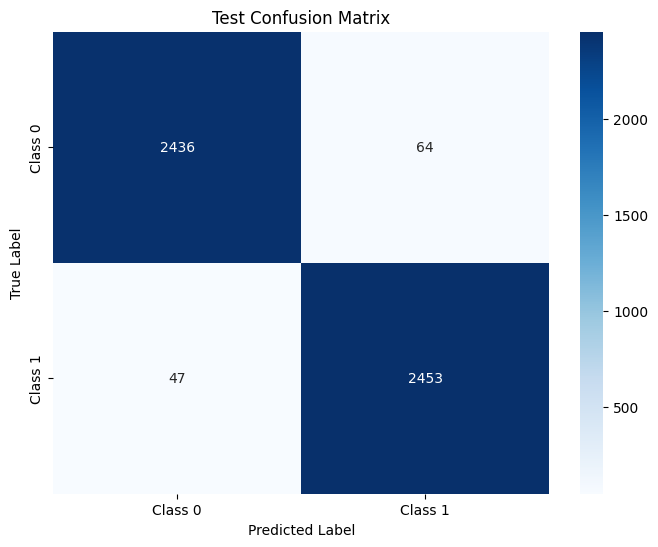

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [35]:
print("Validation Metrics:")
print(f"Accuracy={val_accuracy}, Precision={val_precision}, Recall={val_recall}, F1 Score={val_f1}")

Validation Metrics:
Accuracy=0.9765, Precision=0.9774177712322042, Recall=0.9764590485532123, F1 Score=0.9769381746810597


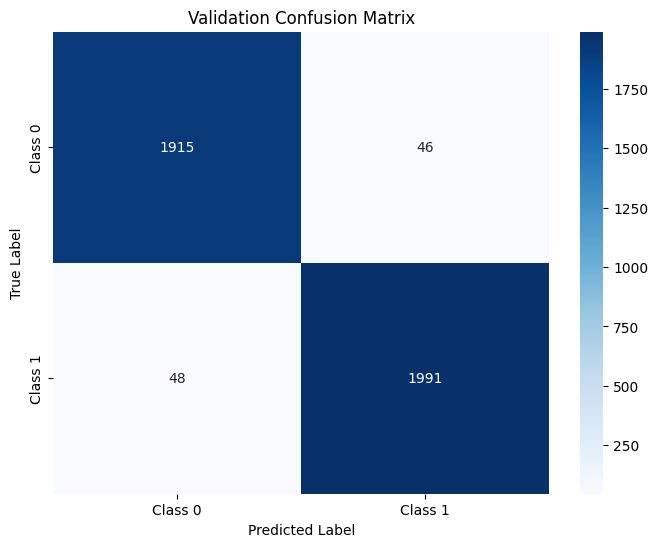

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()